This file contains code related to the following operations -
1. Extraction of reviewer-centric features
2. Extraction of user cluster id feature
3. Merging of all features in a single dataframe and exporting to a csv file
4. Extracting labels and exporting to a separate csv file
5. Model training - Random Classifier - Random Sampling
6. Model training - Random Classifier - Stratifiedkfold Sampling
7. Model training - Naive Bayes Classifier - Stratifiedkfold Sampling

In [ ]:
import numpy as np
import pandas as pd
# from nltk import bigrams,trigrams
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from textblob import TextBlob
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#read reviews, remove stop words and perform stemming

file1 = open("reviewContent")
datareview = []
all_stop_words = stopwords.words('english')
st = PorterStemmer()
for row in file1:
    text = re.split(r'\t+', row)
    row = re.sub('[^a-zA-Z0-9 \n\..]', '', text[-1])
    row = ' '.join([word for word in row.split() if word not in all_stop_words])
    row = ' '.join([st.stem(word) for word in row.split()])
    words = row.split()
    datareview.append(len(words))


file1.close()
print(len(datareview))
for i in range(0, 5):
  print(datareview[i])

359052
24
27
21
52
68


In [ ]:
#read metadata file and extract date, userid, productid, rating and label for each review

file2 = open("metadata")
datauser = []

for row in file2:
    tr = re.split(r'\t+', row)
    temp = []
    #date
    temp.append(tr[4])
    #userid
    temp.append(tr[0])
    #productid
    temp.append(tr[1])
    #rating
    temp.append(tr[2])
    #label
    if tr[3] == "1":
        temp.append(0)
    else:
        temp.append(1)
    datauser.append(temp)
    
file2.close()
print(len(datauser))
for i in range(0, 5):
  print(datauser[i])

359052
['2014-12-08\n', '923', '0', '3.0', 1]
['2013-05-16\n', '924', '0', '3.0', 1]
['2013-07-01\n', '925', '0', '4.0', 1]
['2011-07-28\n', '926', '0', '4.0', 1]
['2010-11-01\n', '927', '0', '4.0', 1]


In [ ]:
#feature extraction - user features

userlist = {}
#["date", "userid", "productid", "rating", "label"]
for i, j in zip(datareview, datauser):
  userid = j[1]
  tr = j
  tr.append(i)
  if userid not in userlist:
    userlist[userid] = []
  userlist[userid].append(tr)

print(len(userlist))
print(userlist.keys())

160225
dict_keys(['923', '924', '925', '926', '927', '928', '929', '930', '931', '932', '933', '934', '935', '936', '937', '938', '939', '940', '941', '942', '943', '944', '945', '946', '947', '948', '949', '950', '951', '952', '953', '954', '955', '956', '957', '958', '959', '960', '961', '962', '963', '964', '965', '966', '967', '968', '969', '970', '971', '972', '973', '974', '975', '976', '977', '978', '979', '980', '981', '982', '983', '984', '985', '986', '987', '988', '989', '990', '991', '992', '993', '994', '995', '996', '997', '998', '999', '1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '1050', '1051', '1052', '1053', '1054', '10

In [ ]:
#feature extraction - user features

userfeatures = []
#["date", "userid", "productid", "rating", "label", "no of words"]
for userid in userlist.keys():
  tr = []
  #user id
  tr.append(userid)
  total, pos, neg = 0, 0, 0
  for i in userlist[userid]:
    total += int(i[-1])
    if float(i[3]) >= 3:
      pos += 1
    else:
      neg += 1
  #average number of words
  tr.append((total / len(userlist[userid])))
  #total number of reviews
  tr.append(len(userlist[userid]))
  #is singleton
  if len(userlist[userid]) > 1:
    tr.append(0)
  else:
    tr.append(1)
  #ratio of positive reviews (> 3)
  tr.append(pos / len(userlist[userid]))
  #ratio of negative reviews (< 3)
  tr.append(neg / len(userlist[userid]))

  date = {}
  for i in userlist[userid]:
    if i[0] not in date:
      date[i[0]] = 0
    date[i[0]] += 1
  #average number of reviews per day
  tr.append(sum(date.values()) / len(date))
  #maximum number of reviews per day
  tr.append(date[max(date, key=date.get)])

  userfeatures.append(tr)

print(len(userfeatures))

finaldata = np.array(userfeatures)
np.savetxt('user.csv', finaldata, delimiter=',', fmt='%s', header="UserID, AvgNoOfWords, TotalReviews, IsSingleton, PosReviewRatio, NegReviewRatio, AvgNoOfReviews, MaxNoOfReviews")

KeyboardInterrupt: ignored

In [ ]:
#feature extraction - user features

import datetime
from datetime import date

def calculateDateVariance(dates):
  diffs = []
  dt = []
  for i in range(0, len(dates)):
    dt.append(dates[i].split("\n")[0])
  #print(dt)
  dates = [datetime.datetime.strptime(ts, "%Y-%m-%d") for ts in dt]
  dates.sort()
  for i in range(1, len(dates)):
    diffs.append(calculateDateDifference(dates[i], dates[i - 1]))
  return np.var(diffs)

def calculateDateDifference(date1, date2):
  delta = date1 - date2
  #print(delta.days)
  return abs(delta.days)

#test = ['2014-12-08\n', '2013-05-16\n','2013-07-01\n', '2011-07-28\n','2010-11-01\n']
#print(calculateDateVariance(test))

In [ ]:
#feature extraction - user features

datevariance = []

for userid in userlist.keys():
  dates = []
  for i in userlist[userid]:
    dates.append(i[0])
  datevariance.append(calculateDateVariance(dates))

print(len(datevariance))
print(datevariance)
np.savetxt('userdatevar.csv', datevariance, delimiter=',', fmt='%s', header="DateVariance")

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


160225
[136.03947368421052, nan, 0.0, nan, 26.1875, nan, nan, 506232.25, 30.49888888888888, nan, nan, nan, nan, nan, 0.0, nan, 0.0, 95318.85, nan, 0.0, 124797.55555555556, 11361.984375, nan, 225.0, 123982.8, nan, 0.0, 0.0, nan, 384.22222222222223, 35840.555555555555, 272.25, 0.0, 1252.6666666666667, nan, 0.0, 878.4487534626038, 2714.6670918367354, 11759.609375, 2511.226658950617, 1789.4273192111032, 57600.0, nan, 699.520551508845, 16641.0, 2340.3599999999997, 2909.8182801514336, 12862.333333333334, 2.6875, 149856.75, 0.0, 0.0, 6006.25, 757.7419525414767, 9040.360000000002, 6661.4375, nan, 0.0, 0.0, 0.0, 34669.234375, nan, 0.0, 5404.6875, 43475.25, nan, 0.0, 17366.22222222222, 20698.204081632655, 5100.6875, nan, 5377.916666666667, 152554.24, 0.0, nan, 736.2222222222222, 4950.651041666667, nan, nan, 186624.0, 1273.3298898071625, 2997.714285714286, 38013.25, nan, 61374.56, 1399.4097222222224, 0.0, 26550.469135802472, 1783.7437130177516, 66520.91666666667, nan, 3560.456597222222, 76.958677

In [ ]:
#feature extraction - clustering data
import datetime
from datetime import date

file2 = open("metadata")
datacluster = []

for row in file2:
    tr = re.split(r'\t+', row)
    temp = []
    date = tr[4].split("\n")[0]
    date = datetime.datetime.strptime(date, "%Y-%m-%d")
    a_timedelta = date - datetime.datetime(1900, 1, 1)
    #date
    temp.append(a_timedelta.total_seconds())
    #userid
    temp.append(int(tr[0]))
    #productid
    temp.append(int(tr[1]))
    datacluster.append(temp)
    
file2.close()
print(len(datacluster))
for i in range(0, 5):
  print(datacluster[i])

359052
[3626985600.0, 923, 0]
[3577651200.0, 924, 0]
[3581625600.0, 925, 0]
[3520800000.0, 926, 0]
[3497558400.0, 927, 0]


In [ ]:
#export clustering features - date, userid, productid

np.savetxt('datacluster.csv', datacluster, delimiter=',', fmt='%s', header="Date, UserID, ProductID")

              # Date    UserID   ProductID
0       3.626986e+09     923.0         0.0
1       3.577651e+09     924.0         0.0
2       3.581626e+09     925.0         0.0
3       3.520800e+09     926.0         0.0
4       3.497558e+09     927.0         0.0
...              ...       ...         ...
359047  3.600634e+09  161146.0       349.0
359048  3.600115e+09  116424.0       349.0
359049  3.600029e+09  161147.0       349.0
359050  3.599597e+09   97930.0       349.0
359051  3.599597e+09    5260.0       349.0

[359052 rows x 3 columns]
[14 47 75 ...  5  5  5]
[141  74 167 ... 156 156 156]
[ 74  28  78 ...  68 214 214]
[141  74 167 ... 240 211 211]
[141  74 167 ... 491 211 211]
[524 208 167 ... 520 211 211]
[524  74 167 ... 520 211 211]
[524  74 167 ... 520 752 752]
[141  74 167 ... 520 832 752]


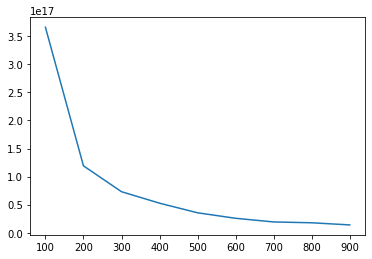

In [ ]:
#clustering - extract user cluster id - date as date value
from sklearn.cluster import KMeans
df = pd.read_csv('datacluster.csv')
print(df)

cost = []
for n in range (100, 1000, 100):
  kmeans = KMeans(init="random", n_clusters=n, n_init=10, max_iter=300, random_state=42).fit(df)
  y = kmeans.predict(df)
  cost.append(kmeans.inertia_)
  print(y)

y = np.array([i for i in range(100,1000,100)])
plt.plot(y,cost)



#!pip install kmodes

In [ ]:
#clustering - extract user cluster id - date in seconds
from sklearn.cluster import KMeans
df = pd.read_csv('datacluster_seconds.csv')
print(df)

kmeans = KMeans(init="random", n_clusters=1000, n_init=10, max_iter=300, random_state=42).fit(df)
y = kmeans.predict(df)
np.savetxt('kmeans_cluster_1000.csv', y, delimiter=',', fmt='%s', header="ClusterID")

              # Date    UserID   ProductID
0       3.626986e+09     923.0         0.0
1       3.577651e+09     924.0         0.0
2       3.581626e+09     925.0         0.0
3       3.520800e+09     926.0         0.0
4       3.497558e+09     927.0         0.0
...              ...       ...         ...
359047  3.600634e+09  161146.0       349.0
359048  3.600115e+09  116424.0       349.0
359049  3.600029e+09  161147.0       349.0
359050  3.599597e+09   97930.0       349.0
359051  3.599597e+09    5260.0       349.0

[359052 rows x 3 columns]


In [ ]:
#load all individual feature files
#product.csv = all product-centric features
#user.csv = all reviewer-centric features
#review_features.csv = all review centric features

product = pd.read_csv('product.csv')
print(product)

user = pd.read_csv('user.csv')
print(user)

reviews = pd.read_csv('review_features.csv')
print(reviews)



     ProductID  MeanRating  numberOfReviews
0            0    4.009524              210
1            1    4.328063              253
2            3    4.169492               59
3            4    4.032907              547
4            5    4.372093               86
..         ...         ...              ...
918        917    3.738776              735
919        902    3.968354              158
920        920    4.094771              306
921        921    4.171875              192
922        349    4.185185              108

[923 rows x 3 columns]
        userID  avgNoOfWords  ...  maxNoOfReviews  dateVariance
0          923     37.410256  ...               3    136.039474
1          924     27.000000  ...               1           NaN
2          925     22.000000  ...               2      0.000000
3          926     52.000000  ...               1           NaN
4          927     86.200000  ...               1     26.187500
...        ...           ...  ...             ...           ...


In [ ]:
#merge all features
#create dictionary of product values
productdct = {}

for index, row in product.iterrows():
  id = int(row['ProductID'])
  if id not in productdct:
    productdct[id] = []
  productdct[id].append(row['MeanRating'])
  productdct[id].append(row['numberOfReviews'])

print(productdct)



{0: [4.00952381, 210.0], 1: [4.328063241000001, 253.0], 3: [4.169491525, 59.0], 4: [4.032906764, 547.0], 5: [4.372093023, 86.0], 6: [4.200787402, 508.0], 7: [3.7518463810000005, 677.0], 8: [3.87654321, 162.0], 9: [3.8426966289999998, 178.0], 10: [4.473895582, 498.0], 11: [4.0, 52.0], 490: [4.313253012, 913.0], 13: [4.02247191, 178.0], 14: [3.9082568810000002, 218.0], 15: [3.93902439, 82.0], 16: [3.97309417, 892.0], 17: [4.1376811589999996, 138.0], 18: [3.919871795, 312.0], 19: [4.037151703, 323.0], 20: [4.322033898, 59.0], 21: [4.366666667, 150.0], 22: [4.234042553, 47.0], 323: [4.244274809, 262.0], 24: [4.0, 224.0], 25: [4.076923077, 130.0], 26: [4.436936937, 222.0], 27: [3.81920904, 177.0], 28: [3.578512397, 121.0], 29: [3.9537037039999996, 432.0], 627: [3.875, 368.0], 31: [4.435483871000001, 62.0], 605: [4.0451127819999995, 266.0], 32: [3.9008620689999995, 232.0], 33: [4.176404494, 1780.0], 34: [4.109090909, 110.0], 35: [4.2028985510000005, 552.0], 36: [3.9936102239999998, 313.0], 3

In [ ]:
#merge all features
#create all product data
productAllData = []

for index,row in reviews.iterrows():
  id = int(row['productid'])
  productAllData.append(productdct[id])

np.savetxt('productAllData.csv', productAllData, delimiter=',', fmt='%s', header="meanRating,numberOfReviews")

In [ ]:
#merge all features
#create dictionary of user values
userdct = {}

for index, row in user.iterrows():
  id = int(row['userID'])
  if id not in userdct:
    userdct[id] = []
  userdct[id].append(row['avgNoOfWords'])
  userdct[id].append(row['totalReviews'])
  userdct[id].append(row['isSingleton'])
  userdct[id].append(row['posReviewRatio'])
  userdct[id].append(row['negReviewRatio'])
  userdct[id].append(row['avgNoOfReviews'])
  userdct[id].append(row['maxNoOfReviews'])
  userdct[id].append(row['dateVariance'])

In [ ]:
#merge all features
#create all user data
userAllData = []

for index,row in reviews.iterrows():
  id = int(row['userid'])
  userAllData.append(userdct[id])

np.savetxt('userAllData.csv', userAllData, delimiter=',', fmt='%s', header="avgNoOfWords,totalReviews,isSingleton,posReviewRatio,negReviewRatio,avgNoOfReviews,maxNoOfReviews,dateVariance")

In [ ]:
#export labels for all review in a separate file

file2 = open("metadata")
labels = []
pos, neg = 0, 0
for row in file2:
    tr = re.split(r'\t+', row)
    if tr[3] == "1":
        labels.append(0)
        pos +=1 
    else:
        labels.append(1)
        neg += 1

print(pos)
#np.savetxt('labels.csv', labels, delimiter=',', fmt='%s', header="Label")

In [ ]:
np.savetxt('labels.csv', labels, delimiter=',', fmt='%s', header="Label")

In [ ]:
#load all features

X = pd.read_csv('featuresAll.csv')
print(X.head())
X = X.to_numpy()

#load all labels
Y = pd.read_csv('labels.csv')
print(Y.head())
y = Y['label']

   polarity  subjectivity  ...  maxNoOfReviews  dateVariance
0  0.195833      0.395833  ...               3  1.360395e+02
1  0.025000      0.650000  ...               1  2.003740e+06
2  0.220000      0.328718  ...               2  0.000000e+00
3  0.555134      0.776786  ...               1  2.003740e+06
4  0.138715      0.538294  ...               1  2.618750e+01

[5 rows x 17 columns]
   label
0      1
1      1
2      1
3      1
4      1


In [ ]:
#perform classification using - random forest classifier
#all records are scalled and this uses random sampling

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=53)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=56)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(y_pred)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

In [ ]:
#perform classification using - random forest classifier
#all records are scalled and this uses stratifiedkfold sampling

from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


sc = StandardScaler()
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
clf = RandomForestClassifier(n_estimators=50, random_state=56)

for train_ix, test_ix in skf.split(X, y):
  train_X, test_X = X[train_ix], X[test_ix]
  train_y, test_y = y[train_ix], y[test_ix]
  train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
  test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
  print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

  train_X = sc.fit_transform(train_X)
  test_X = sc.transform(test_X)
  clf.fit(train_X, train_y)
  y_pred = clf.predict(test_X)
  print(confusion_matrix(test_y,y_pred))
  print(classification_report(test_y,y_pred))
  print(accuracy_score(test_y, y_pred))
  

>Train: 0=257733, 1=29508, Test: 0=64434, 1=7377
[[64231   203]
 [ 6830   547]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     64434
           1       0.73      0.07      0.13      7377

    accuracy                           0.90     71811
   macro avg       0.82      0.54      0.54     71811
weighted avg       0.89      0.90      0.86     71811

0.9020623581345476
>Train: 0=257733, 1=29508, Test: 0=64434, 1=7377
[[64269   165]
 [ 6973   404]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     64434
           1       0.71      0.05      0.10      7377

    accuracy                           0.90     71811
   macro avg       0.81      0.53      0.52     71811
weighted avg       0.88      0.90      0.86     71811

0.9006001866009385
>Train: 0=257734, 1=29508, Test: 0=64433, 1=7377
[[62067  2366]
 [ 6401   976]]
              precision    recall  f1-score   support

           0 

In [ ]:
#perform classification using - naive bayes classifier
#all records are scalled and this uses stratifiedkfold sampling

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


sc = StandardScaler()
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
clf =  GaussianNB()

for train_ix, test_ix in skf.split(X, y):
  train_X, test_X = X[train_ix], X[test_ix]
  train_y, test_y = y[train_ix], y[test_ix]
  train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
  test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
  print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

  train_X = sc.fit_transform(train_X)
  test_X = sc.transform(test_X)
  clf.fit(train_X, train_y)
  y_pred = clf.predict(test_X)
  print(confusion_matrix(test_y,y_pred))
  print(classification_report(test_y,y_pred))
  print(accuracy_score(test_y, y_pred))

>Train: 0=257733, 1=29508, Test: 0=64434, 1=7377
[[51131 13303]
 [ 3210  4167]]
              precision    recall  f1-score   support

           0       0.94      0.79      0.86     64434
           1       0.24      0.56      0.34      7377

    accuracy                           0.77     71811
   macro avg       0.59      0.68      0.60     71811
weighted avg       0.87      0.77      0.81     71811

0.7700491568144157
>Train: 0=257733, 1=29508, Test: 0=64434, 1=7377
[[51313 13121]
 [ 3201  4176]]
              precision    recall  f1-score   support

           0       0.94      0.80      0.86     64434
           1       0.24      0.57      0.34      7377

    accuracy                           0.77     71811
   macro avg       0.59      0.68      0.60     71811
weighted avg       0.87      0.77      0.81     71811

0.7727089164612664
>Train: 0=257734, 1=29508, Test: 0=64433, 1=7377
[[49130 15303]
 [ 2958  4419]]
              precision    recall  f1-score   support

           0 